In [ ]:
!pip install pvlib
!pip install --force-reinstall --no-deps git+https://github.com/isi-ies-group/cpvlib.git

In [1]:
import pandas as pd
import pvlib
import datetime
import matplotlib.pyplot as plt
import numpy as np
from cpvlib import cpvsystem

# Parámetros de los módulos

In [2]:
mod_params_vidrio = {
    'alpha_sc': 0.0008*8.93,#temp coef of Isc 0.007144
    'a_ref': 0.712,
    'I_L_ref': 8.994,
    'I_o_ref': 0.00000157,
    'R_s': 0.01,
    'R_sh_ref': 3000,
    'EgRef': 1.121,
}

system = {   
    'surface_tilt': 30,      #Inclinación
    'surface_azimuth': 180,  #ángulo de la proyección en el suelo a la direccion norte
}

mod_params_cpv = {
    "gamma_ref": 5.524,
    "mu_gamma": 0.003,
    "I_L_ref": 0.96*0.9,
    "I_o_ref": 1.7e-10,
    "R_sh_ref": 5226,
    "R_sh_0": 21000,
    "R_sh_exp": 5.50,
    "R_s": 0.01,
    "alpha_sc": 0.00,
    "EgRef": 3.91,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 12,
    "eta_m": 0.32,
    "alpha_absorption": 0.9,
    "b": 0.7,
    "iam_model": 'ashrae',
    "theta_ref": [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60],
    "iam_ref": [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387],
}

UF_parameters_cpv = {
    "IscDNI_top": 0.96 / 1000,
    "am_thld": 4.574231933073185,
    "am_uf_m_low": 3.906372068620377e-06,
    "am_uf_m_high": -3.0335768119184845e-05,
    "ta_thld": 50,
    "ta_uf_m_low": 4.6781224141650075e-06,
    "ta_uf_m_high": 0,
    "weight_am": 0.2,
    "weight_temp": 0.8,
}

mod_params_cpv.update(UF_parameters_cpv)

# example (NO Insolight) PV module from:
# https://pvpmc.sandia.gov/PVLIB_Matlab_Help/html/pvl_calcparams_PVsyst_help.html
mod_params_flatplate = {
    "gamma_ref": 1.1,
    "mu_gamma": -0.0003,
    "I_L_ref": 8,
    "I_o_ref": 2.2e-9,
    "R_sh_ref": 200,
    "R_sh_0": 8700,
    "R_sh_exp": 5.5,
    "R_s": 0.33,
    "alpha_sc": -0.002,
    "EgRef": 1.121,
    "irrad_ref": 1000,
    "temp_ref": 25,
    "cells_in_series": 4, # 60,
    "eta_m": 0.95,  # pvsyst_celltemp() default value
    "alpha_absorption": 0.97,  # pvsyst_celltemp() default value
    "aoi_limit": 55,
}

# Funciones

In [3]:
def obtencionDatos(name, lat, lon, alt, tz):
    data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)
    data = data_pvgis[0].rename(columns={
        'Gb(n)': 'dni',
        'G(h)': 'ghi',
        'Gd(h)': 'dhi',
        'T2m': 'temp_air',
        'WS10m': 'wind_speed',
    })
    data = data.set_index(
        data.index.map(lambda t: t.replace(year=2010)))

    location = pvlib.location.Location(latitude=lat, 
                                       longitude=lon, 
                                       altitude=alt, 
                                       tz=tz)
    data['solar_zenith'] = pvlib.solarposition.get_solarposition(data.index, lat, lon).zenith
    data['solar_azimuth'] = pvlib.solarposition.get_solarposition(data.index, lat, lon).azimuth
    data['airmass_absolute'] = location.get_airmass(data.index).airmass_absolute
    return data

In [4]:
def generacionVidrio(params, system, data):
    dii = pvlib.irradiance.beam_component(system['surface_tilt'],
                                          system['surface_azimuth'],
                                          solar_zenith=data['solar_zenith'],
                                          solar_azimuth=data['solar_azimuth'],
                                          dni=data['dni'])

    aoi = pvlib.irradiance.aoi(system['surface_tilt'], 
                               system['surface_azimuth'],
                               solar_zenith=data['solar_zenith'],
                               solar_azimuth=data['solar_azimuth'])

    poa_sky=pvlib.irradiance.get_sky_diffuse(system['surface_tilt'],
                                             system['surface_azimuth'],
                                             solar_zenith=data['solar_zenith'],
                                             solar_azimuth=data['solar_azimuth'],
                                             ghi=data['ghi'],
                                             dhi=data['dhi'],
                                             dni=data['dni'],
                                             dni_extra=None, 
                                             airmass=None, 
                                             model='isotropic', 
                                             model_perez='allsitescomposite1990')

    poa_ground=pvlib.irradiance.get_ground_diffuse(system['surface_tilt'], 
                                                   ghi=data['ghi'], 
                                                   albedo=0.25, 
                                                   surface_type=None)

    poa_irrad=pvlib.irradiance.poa_components(aoi=aoi, 
                                              dni=data['dni'], 
                                              poa_sky_diffuse=poa_sky, 
                                              poa_ground_diffuse=poa_ground)

    effectiveIrradiance = poa_irrad.poa_direct * np.absolute(np.cos(aoi)) * pvlib.iam.ashrae(aoi) + poa_irrad.poa_diffuse

    tempcell=pvlib.temperature.pvsyst_cell(poa_irrad.poa_global, 
                                       data['temp_air'], 
                                       data['wind_speed'])

    IL, I0, Rs, Rsh, nNsVth = pvlib.pvsystem.calcparams_desoto(
        effective_irradiance=effectiveIrradiance,
        temp_cell=tempcell,
        alpha_sc=mod_params_vidrio['alpha_sc'],
        a_ref=mod_params_vidrio['a_ref'],
        I_L_ref=mod_params_vidrio['I_L_ref'],
        I_o_ref=mod_params_vidrio['I_o_ref'],
        R_sh_ref=mod_params_vidrio['R_sh_ref'],
        R_s=mod_params_vidrio['R_s'],
        EgRef=mod_params_vidrio['EgRef'],
    )

    dc_pv = pvlib.pvsystem.singlediode(
        photocurrent=IL,
        saturation_current=I0,
        resistance_series=Rs,
        resistance_shunt=Rsh,
        nNsVth=nNsVth,
        ivcurve_pnts=100,
        method='lambertw'
    )
    
    dc = pd.DataFrame(dc_pv['p_mp'], index = data.index)
    
    return dc

In [5]:
def generacionCPV(paramsCPV, paramsFlatPlate, system, data):
    static_hybrid_sys = cpvsystem.StaticHybridSystem(
        surface_tilt=system['surface_tilt'],
        surface_azimuth=system['surface_azimuth'],
        module_cpv=None,
        module_flatplate=None,
        module_parameters_cpv=paramsCPV,
        module_parameters_flatplate=paramsFlatPlate,
        modules_per_string=1,
        strings_per_inverter=1,
        inverter=None,
        inverter_parameters=None,
        racking_model="insulated",
        losses_parameters=None,
        name=None,
    )

    dii_effective, poa_flatplate_static_effective = static_hybrid_sys.get_effective_irradiance(
        data['solar_zenith'],
        data['solar_azimuth'],
        #iam_param=0.7,
        #aoi_limit=55,
        dii=None,
        ghi=data['ghi'],
        dhi=data['dhi'],
        dni=data['dni']
    )


    temp_cell_35, temp_cell_flatplate = static_hybrid_sys.pvsyst_celltemp(
        dii=dii_effective,
        poa_flatplate_static=poa_flatplate_static_effective,
        temp_air=data['temp_air'],
        wind_speed=data['wind_speed']
    )

    diode_parameters_cpv, diode_parameters_flatplate = static_hybrid_sys.calcparams_pvsyst(
        dii=dii_effective,
        poa_flatplate_static=poa_flatplate_static_effective,
        temp_cell_cpv=temp_cell_35,
        temp_cell_flatplate=temp_cell_flatplate,
    )

    dc_cpv, dc_flatplate = static_hybrid_sys.singlediode(
        diode_parameters_cpv, diode_parameters_flatplate)

    uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(data['airmass_absolute'],
                                                                 data['temp_air'])

    return dc_cpv['p_mp'] * uf_cpv + dc_flatplate['p_mp']

In [6]:
Madrid = obtencionDatos('Madrid', 40.421707, -3.612245, 695, 'utc')
Vivares = obtencionDatos('Madrid', 39.085667, -5.898909, 283, 'utc')

In [7]:
vidrioMad = generacionVidrio(mod_params_vidrio, system, Madrid)
vidrioViv = generacionVidrio(mod_params_vidrio, system, Vivares)

In [8]:
CPVMad = generacionCPV(mod_params_cpv, mod_params_flatplate, system, Madrid)
CPVViv = generacionCPV(mod_params_cpv, mod_params_flatplate, system, Vivares)

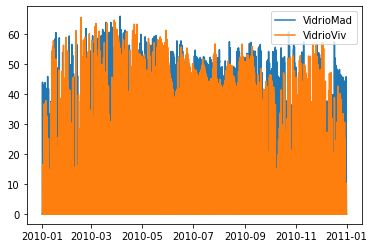

In [9]:
plt.plot(vidrioMad, label='VidrioMad')
plt.plot(vidrioViv, label='VidrioViv')
plt.legend()
plt.show()

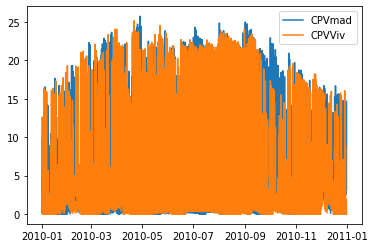

In [10]:
plt.plot(CPVMad, label='CPVmad')
plt.plot(CPVViv, label='CPVViv')
plt.legend()
plt.show()

In [11]:
vidrioMad.sum()

0    92294.517877
dtype: float64

In [12]:
vidrioViv.sum()

0    87332.944033
dtype: float64

In [13]:
CPVMad.sum()

34227.33575228512

In [14]:
CPVViv.sum()

33125.61701864894